In [ ]:
# import tensorflow as tf
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# from collections import Counter
# import random
# import matplotlib.pyplot as plt
# import numpy as np

In [14]:
data_set = 'subject1' # data_set name
samples_per_state = 100 # no. of samples considering per state
window_len = 250 # 25s window length
epochs = 10 

img_sizes = [10,20] # size of the images
err_percentages = [0.05, 0.1] # percentage of total pixel corruption to be added in the image

In [27]:
import numpy as np
def create_binary_image(sub_readings, img_size, global_min=0, global_max=1):
  normalised_readings = (sub_readings - global_min)/(global_max - global_min)
  bi_img = -np.ones((img_size, img_size))
  for i, value in enumerate(normalised_readings): #need indices along with values, hence using enumerate
    y_coord = (int)(value * (img_size-1))
    x_coord = (int)(i*(img_size-1)/(len(normalised_readings)-1))
    bi_img[(img_size-1)-y_coord, x_coord]=1
    return bi_img


In [18]:
import random
import matplotlib.pyplot as plt

def draw_binary_image( image_set, example_images=10):
    fig, axes = plt.subplots(len(image_set.keys()), example_images, figsize=(10, 10))

    for i, (state, images) in enumerate(image_set.items()):
        random_samples = random.sample(images, min(example_images, len(images)))
        for j, img in enumerate(random_samples):
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"State {state}")
  
    plt.show()

In [32]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_CNN_model(train_images, test_images, image_size,err_percentage, epochs):
    unique_labels = list(set([label for _, label in train_images + test_images]))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}

    train_images_array = np.array([img for img, _ in train_images])
    train_labels_array = np.array([label_to_int[label] for _, label in train_images])

    test_images_array = np.array([img for img, _ in test_images])
    test_labels_array = np.array([label_to_int[label] for _, label in test_images])

    # Model
    model = tf.keras.Sequential([
    tf.keras.layers.Reshape((image_size, image_size, 1), input_shape=(image_size, image_size)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(unique_labels), activation='softmax')
    ])

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


    # Training
    history = model.fit(
        train_images_array, train_labels_array, 
        epochs=epochs,
        validation_split=0.1  # 1% of the training data is used as the validation set
    )

    # Evaluation
    test_loss, test_acc = model.evaluate(test_images_array, test_labels_array)
    print(f'Test accuracy: {test_acc}')

    # Confusion Matrix with Normalization
    predicted_labels = model.predict(test_images_array)
    predicted_labels = np.argmax(predicted_labels, axis=1)
    cm = confusion_matrix(test_labels_array, predicted_labels)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting the normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    #save_path = f'{dir_name}/cm_imgsiz{image_size}_epoch{n_epochs}_err{err_percentage}.svg'
    #plt.savefig(save_path, dpi=300, format='svg')
    plt.show()
    
    return test_acc, cm_normalized


In [34]:
from collections import Counter
import pickle
import random
import numpy as np

def no_artifact(data_set, samples_per_state, window_len, size, err, epochs):
    recording_data = np.load('./data/subset_data_subject1.npy')
    with open(f"./data/subset_metadata_subject1.pkl",'rb') as f:
        recording_metadata = pickle.load(f)
        state_labels = recording_metadata['GT']

    unique_states = np.unique(state_labels)
    readings = {state : np.where(state_labels==state)[0] for state in unique_states}

    global_min= np.min([np.min(recording_data[readings[state]]) for state in unique_states]) * 1.25
    global_max=np.max([np.max(recording_data[readings[state]]) for state in unique_states]) * 0.75

    bi_images = {state : [] for state in unique_states}

    for state, state_rows in readings.items():
        for row_id in state_rows:
            for i in range(0, len(recording_data[row_id]), window_len):
                sub_readings = recording_data[row_id][i:i+window_len]
                if(len(sub_readings)==window_len):  #because the readings might be less than window_len sometimes, ignore those
                    temp_binary_img= create_binary_image(sub_readings, size, global_min, global_max)
                    bi_images[state].append(temp_binary_img)
        print(f"Generated {len(bi_images[state])} binary images for state {state}")

    no_of_neurons = size * size
    maximum_patterns = int(0.138 * no_of_neurons)

    train_images=[]
    test_images=[]
    for state, images in bi_images.items():
      random.shuffle(images)
      train_split = min (int(0.1 * len(bi_images[state])), len(images))
      train_images_temp = images[:train_split]
      train_images+=[(img,state) for img in train_images_temp]
      test_images_temp = images[train_split:]
      test_images+=[(img,state) for img in test_images_temp]


    state_counts_train = Counter(label for _, label in train_images)
    print("Count of binary images for training of each state:")
    for state, count in state_counts_train.items():
        print(f"State {state}: {count} images")

    state_counts_test = Counter(label for _, label in test_images)
    print("Count of binary images for testing of each state:")
    for state, count in state_counts_test.items():
        print(f"State {state}: {count} images")

    print(f"Number of train_images: {len(train_images)}")
    print(f"Number of test_images: {len(test_images)}")

    train_dict = {}
    test_dict = {}
    for img, state in train_images:
        if state not in train_dict:
            train_dict[state] = []
        train_dict[state].append(img)

    for img, state in test_images:
        if state not in test_dict:
            test_dict[state] = []
        test_dict[state].append(img)

    print("Training Images:")
    draw_binary_image(train_dict)
    print("Testing Images:")
    draw_binary_image(test_dict)


  
    test_acc, cm_normalized = train_CNN_model( train_images, test_images, image_size=size,
                                                       err_percentage=err, epochs=epochs)

    return test_acc, cm_normalized

Generated 2304 binary images for state MA
Generated 2304 binary images for state awake
Generated 2304 binary images for state slow_updown
Count of binary images for training of each state:
State MA: 230 images
State awake: 230 images
State slow_updown: 230 images
Count of binary images for testing of each state:
State MA: 2074 images
State awake: 2074 images
State slow_updown: 2074 images
Number of train_images: 690
Number of test_images: 6222
Training Images:


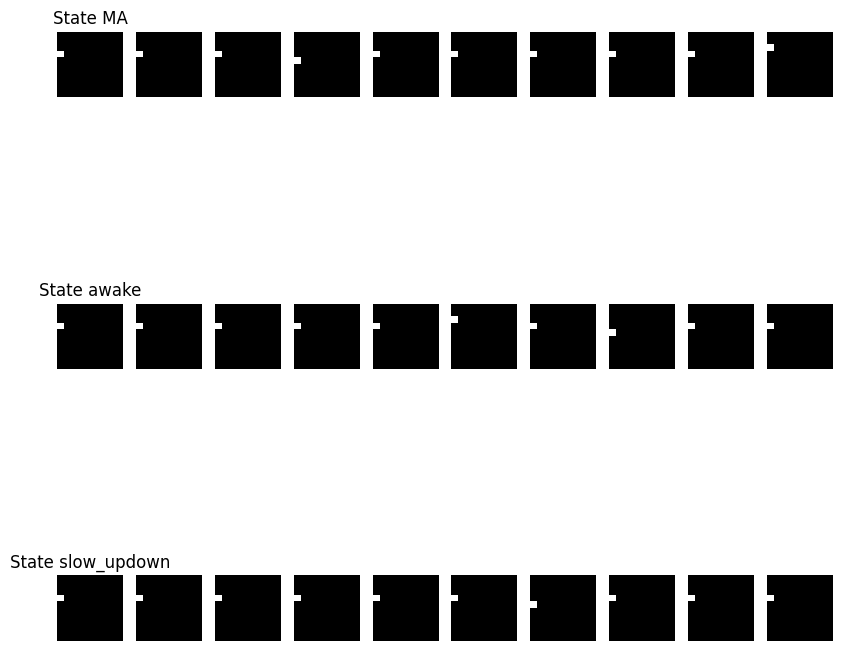

Testing Images:


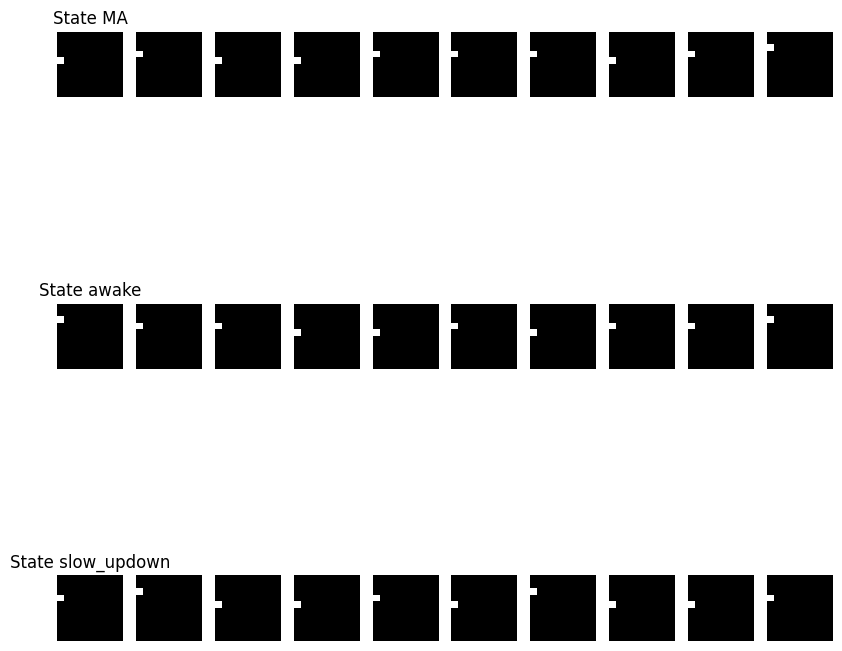

Epoch 1/10
20/20 [==============================] - 0s 7ms/step - loss: 1.0928 - accuracy: 0.3527 - val_loss: 1.4429 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0889 - accuracy: 0.3317 - val_loss: 1.2543 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 1.0869 - accuracy: 0.3704 - val_loss: 1.3739 - val_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0864 - accuracy: 0.3704 - val_loss: 1.3520 - val_accuracy: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0866 - accuracy: 0.3639 - val_loss: 1.3301 - val_accuracy: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0854 - accuracy: 0.3607 - val_loss: 1.3394 - val_accuracy: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0849 - accuracy: 0.3704 - val_loss: 1.3346 - val_accuracy: 0.0

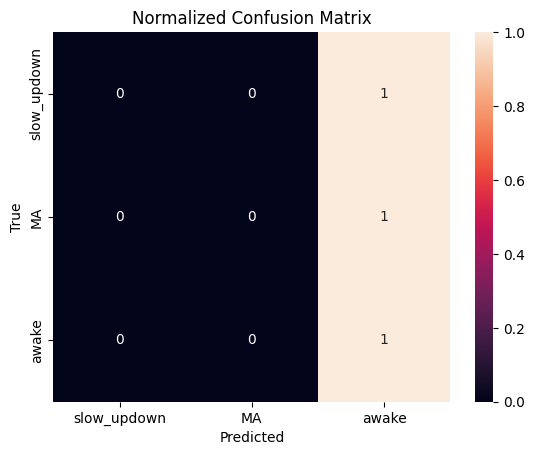

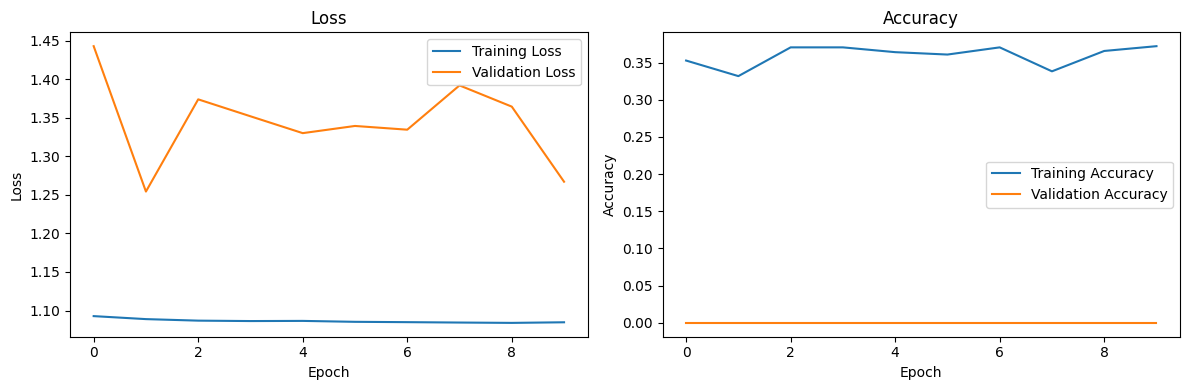

Generated 2304 binary images for state MA
Generated 2304 binary images for state awake
Generated 2304 binary images for state slow_updown
Count of binary images for training of each state:
State MA: 230 images
State awake: 230 images
State slow_updown: 230 images
Count of binary images for testing of each state:
State MA: 2074 images
State awake: 2074 images
State slow_updown: 2074 images
Number of train_images: 690
Number of test_images: 6222
Training Images:


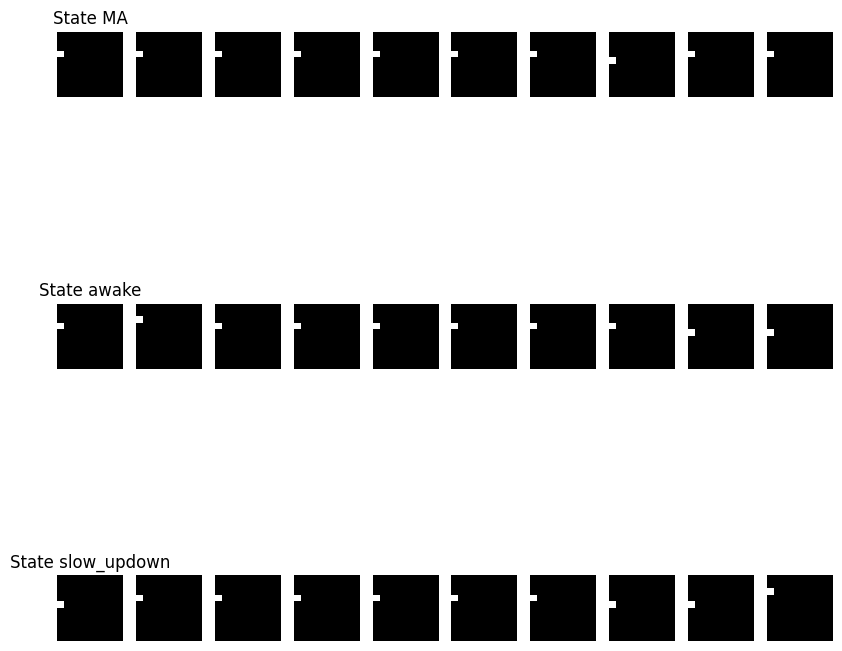

Testing Images:


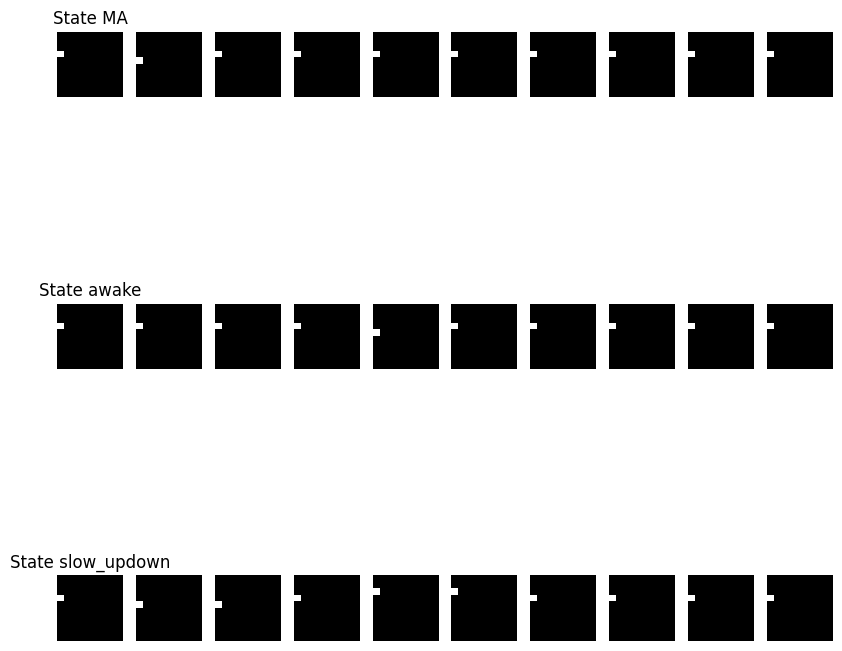

Epoch 1/10
20/20 [==============================] - 1s 15ms/step - loss: 1.0914 - accuracy: 0.3527 - val_loss: 1.3347 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0878 - accuracy: 0.3462 - val_loss: 1.3710 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0879 - accuracy: 0.3704 - val_loss: 1.3656 - val_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0896 - accuracy: 0.3704 - val_loss: 1.2904 - val_accuracy: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0898 - accuracy: 0.3575 - val_loss: 1.3076 - val_accuracy: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0872 - accuracy: 0.3671 - val_loss: 1.3206 - val_accuracy: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0865 - accuracy: 0.3221 - val_loss: 1.3298 - val_accuracy: 0.

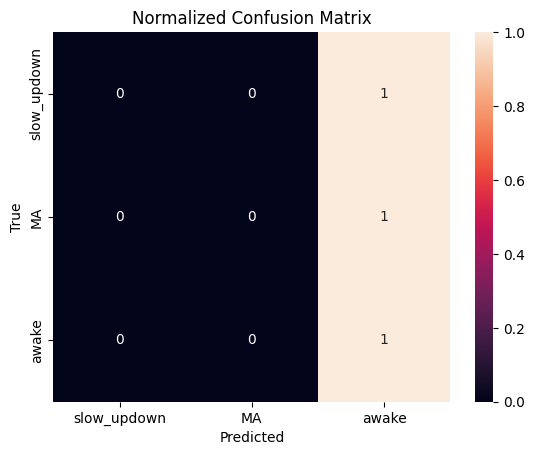

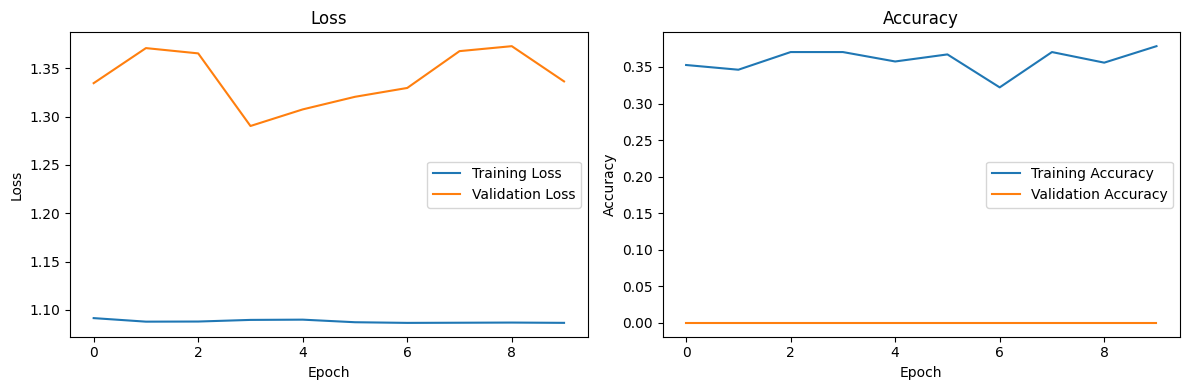

AttributeError: 'DataFrame' object has no attribute 'append'

In [35]:
import pandas as pd
import numpy as np
from statistics import mean

column_headers = ['error_percent', 'image_size', 'test_accuracy', 'confusion_matrix']
no_artifact_df = pd.DataFrame(columns=column_headers)

for err in err_percentages:
    for size in img_sizes:
      if any((no_artifact_df['error_percent']==err) & (no_artifact_df['image_size']==size)):
        print('Already computed',err,size)
        continue
      test_acc=[]
      cm=[]
      runs = 2
      for _ in range(runs):
        
        accuracy, cm_normalized = no_artifact(data_set, samples_per_state, window_len, size, err, epochs)
        test_acc.append(accuracy)
        cm.append(cm_normalized)
     
      avg_test_accuracy = mean(test_acc)
      avg_cm_normalized = np.mean(cm, axis=0).tolist()

      no_artifact_df = no_artifact_df.append({
         'error_percent': err ,
         'image_size' : str(size) ,
         'test_accuracy' : avg_test_accuracy,
         'confusion_matrix' : avg_cm_normalized
      })

no_artifact_df.to_csv('noartifact_results.csv',index=False)
print(f"Results saved to noartifact_results.csv")

In [ ]:
def 